In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
import pyarrow
import fastparquet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import csv
import textwrap
from scipy.spatial.distance import cosine

import spacy
from collections import defaultdict 
from tqdm import tqdm

2024-03-29 00:32:24.654756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ACL Archive Data

This notebook develops a script for extracting sentences containing a set of target metapragmatic words from the acl archive. Dataset available here: https://paperswithcode.com/dataset/acl-anthology-corpus-with-full-text

Load the data from .parquet format

In [2]:
parquet_file = "/Volumes/data_gabriella_chronis/corpora/acl-publication-info.74k.parquet"

df = pd.read_parquet(parquet_file, engine='pyarrow')

In [3]:
df.head()

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,booktitle,author,title,pages,doi,number,volume,journal,editor,isbn
0,O02-2002,There is a need to measure word similarity whe...,There is a need to measure word similarity whe...,18022704,0b09178ac8d17a92f16140365363d8df88c757d0,14,https://aclanthology.org/O02-2002,None,None,2002,...,International Journal of Computational Linguis...,"Chen, Keh-Jiann and\nYou, Jia-Ming",A Study on Word Similarity using Context Vecto...,37--58,None,None,None,None,None,None
1,L02-1310,,,8220988,8d5e31610bc82c2abc86bc20ceba684c97e66024,93,http://www.lrec-conf.org/proceedings/lrec2002/...,European Language Resources Association (ELRA),"Las Palmas, Canary Islands - Spain",2002,...,Proceedings of the Third International Confere...,"Mihalcea, Rada F.",Bootstrapping Large Sense Tagged Corpora,None,None,None,None,None,None,None
2,R13-1042,Thread disentanglement is the task of separati...,Thread disentanglement is the task of separati...,16703040,3eb736b17a5acb583b9a9bd99837427753632cdb,10,https://aclanthology.org/R13-1042,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,Proceedings of the International Conference Re...,"Jamison, Emily and\nGurevych, Iryna","Headerless, Quoteless, but not Hopeless? Using...",327--335,None,None,None,None,None,None
3,W05-0819,"In this paper, we describe a word alignment al...","In this paper, we describe a word alignment al...",1215281,b20450f67116e59d1348fc472cfc09f96e348f55,15,https://aclanthology.org/W05-0819,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,Proceedings of the {ACL} Workshop on Building ...,"Aswani, Niraj and\nGaizauskas, Robert",Aligning Words in {E}nglish-{H}indi Parallel C...,115--118,None,None,None,None,None,None
4,L02-1309,,,18078432,011e943b64a78dadc3440674419821ee080f0de3,12,http://www.lrec-conf.org/proceedings/lrec2002/...,European Language Resources Association (ELRA),"Las Palmas, Canary Islands - Spain",2002,...,Proceedings of the Third International Confere...,"Suyaga, Fumiaki and\nTakezawa, Toshiyuki and...",Proposal of a very-large-corpus acquisition me...,None,None,None,None,None,None,None


In [4]:
df.iloc[10000]["full_text"][:1000]

'Progress in Question Answering can be achieved by (1) combining multiple strategies that optimally resolve different question classes of various degrees of complexity; (2) enhancing the precision of question interpretation and answer extraction; and (3) question decomposition and answer fusion. In this paper we also present the impact of modeling the user background on Q/A and discuss the pragmatics pf processing negation in Q/A. Introduction Our fundamental premise is that progress in Q/A cannot be achieved only by enhancing the processing components, but it also requires generating the best strategies for processing each individual question. Thus we believe that Q/A systems capable of successfully processing complex questions should employ multiple strategies instead of the current pipeline approach, consisting of (1) question processing, (2) passage retrieval and (3) answer selection. The pipeline architecture was reported in (Prager et al., 2000; Moldovan et al., 2000; Hovy et al.

In [5]:
# number of papers
len(df)

73285

In [6]:
# length of one paper
print(len(df.iloc[10000]["full_text"]))
print(len(df.iloc[70000]["full_text"]))


30751
14799


So we are probably working with something like 30k x 70k words which is 2100k which is 2.1 million words? Thats not so bad. 

In [7]:
print(df.year.min())
print(df.year.max())

1952
2022


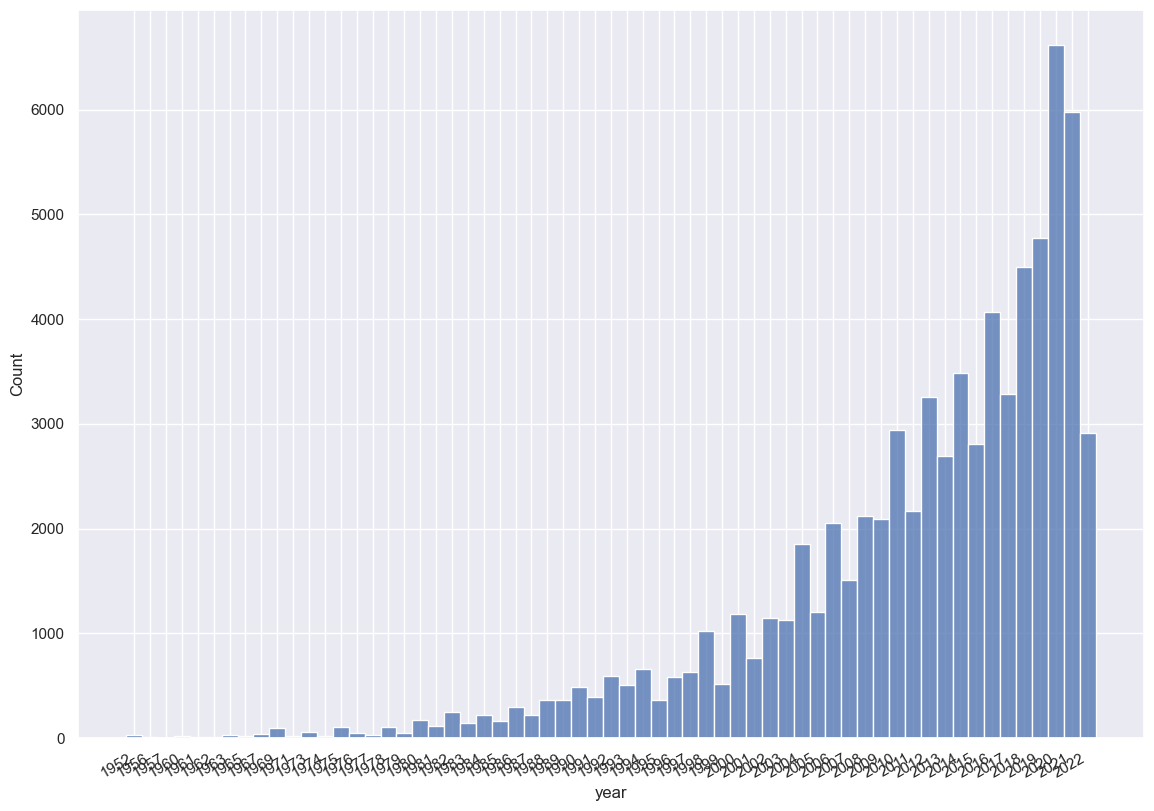

In [8]:
# plot of the number of papers per year

df['year'] = df.year.astype('category')

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(data=df, x="year", bins=10)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [9]:
targets = ["language", "say", "correct"]

In [12]:
from spacy.matcher import PhraseMatcher, Matcher

#nlp = spacy.load('en_core_web_sm') # Load the English Model
nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])
nlp.add_pipe('sentencizer')

def build_phrase_matcher(targets=None):
    """
    expects a dictionary of match labels and phrases. If not provided, uses targets defined in this function
    """
    print(targets)

    phrase_matcher = Matcher(nlp.vocab)
    # phrases = ['language', 'model', 'intelligence', 'predict', 'human']
    # patterns = [nlp(text) for text in phrases]
    # phrase_matcher.add('AI', None, *patterns)
    # phrase_matcher.add('say', None, *[nlp(text) for text in ['say', 'said', 'speak', 'spoke']])


    for word in targets:
        print(word)
        phrase_matcher.add(word, [[{"orth": word}]])
        nlp.vocab.strings.add(word)
    
    return phrase_matcher

def add_matches_to_dict(match_list, match_dict, doc_id, sent_text):
    """
    match list is in the form of a list of tuples [(match_phrase_id, start index, end index)]
    """
    for match in match_list:
        word = match[0]
        start_idx = match[1]
        end_idx = match[2]
        entry = {"corpus_id": doc_id, "sentence": sent_text, "start_idx": start_idx, "end_idx": end_idx}
        match_dict[word].append(entry)
    return match_dict

def get_matches_in_doc(doc_id, doc_text, phrase_matcher, matches=None):
    """
    searches through a docstring to extract a given token.
    ::
    """
    if matches is None:
        matches = defaultdict(list)
    
    doc = nlp(doc_text)
    for sent in doc.sents:
        # this will be a list of tuples
        this_sent_matches = phrase_matcher(nlp(sent.text))
        matches = add_matches_to_dict(this_sent_matches, matches, doc_id, sent)
        
    return matches


def get_matches_in_corpus(df, targets, phrase_matcher=phrase_matcher, outdir=None):

    if phrase_matcher is None:
        phrase_matcher = build_phrase_matcher(targets = targets)
    
    matches = defaultdict(list)
    for idx, row in tqdm(df.iterrows()):
        matches = get_matches_in_doc(row.corpus_paper_id, row.full_text, phrase_matcher, matches)
        #print(matches)
    #get the word as opposed to the spacy vocab id
    for key in list(matches.keys()):
        word = nlp.vocab.strings[key]
        
        matches_df = pd.DataFrame.from_records(matches.pop(key))
        if outdir:
            matches_df.to_csv(outdir+'/'+word+'.csv')


# TEST
#phrase_matcher = build_phrase_matcher(targets=targets)
#print(phrase_matcher)
#m = get_matches_in_doc( df.corpus_paper_id[1000], df.full_text[1000], phrase_matcher)


#m = get_matches_in_corpus(df[:2], targets, outdir='./data/test', phrase_matcher=phrase_matcher)

In [14]:
# get all matches for a couple words

#targets = ["reason", "intuition", "rational", "human", "logic", "fact", "true", "truth", "false", "refer"]
#targets = ["meaning"]
#targets = ["bias", "behavior", "desired", "rationality", "interpretation", "representation"]
targets = ["toxic", "toxicity", "hallucination", "hallucinate", "safe", "safety"]

outdir = 'collected_tokens/acl'
phrase_matcher = build_phrase_matcher(targets=targets)

get_matches_in_corpus(df, targets, outdir=outdir, phrase_matcher=phrase_matcher)

['toxic', 'toxicity', 'hallucination', 'hallucinate', 'safe', 'safety']
toxic
toxicity
hallucination
hallucinate
safe
safety


73285it [26:09, 46.71it/s] 


In [ ]:
nlp.vocab[5530044837203964789]

# 

# 